# Setups, Installations and Imports

In [1]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-05-05 16:54:47.937674: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 16:54:48.006224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 16:54:48.135386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 16:54:48.136139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
# !pip install wandb -q
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.config.experimental.list_physical_devices('GPU'))



2.6.3
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-05-05 16:55:19.883645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 16:55:19.884544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 16:55:19.885190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [5]:
## Cifar 100 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


169017344/169001437 [==============================] - 7s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 100

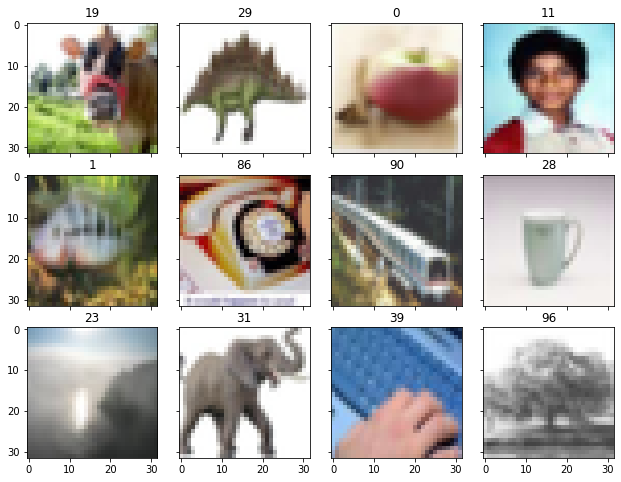

In [6]:
## Get first 32 images as samples
sample_images = x_train[:12]
sample_labels = y_train[:12]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3,4 ),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()



#### Data Generator with Patch Augmentation

In [30]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=512, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(2, 6)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [31]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

In [32]:
len(traingen)*512

49664

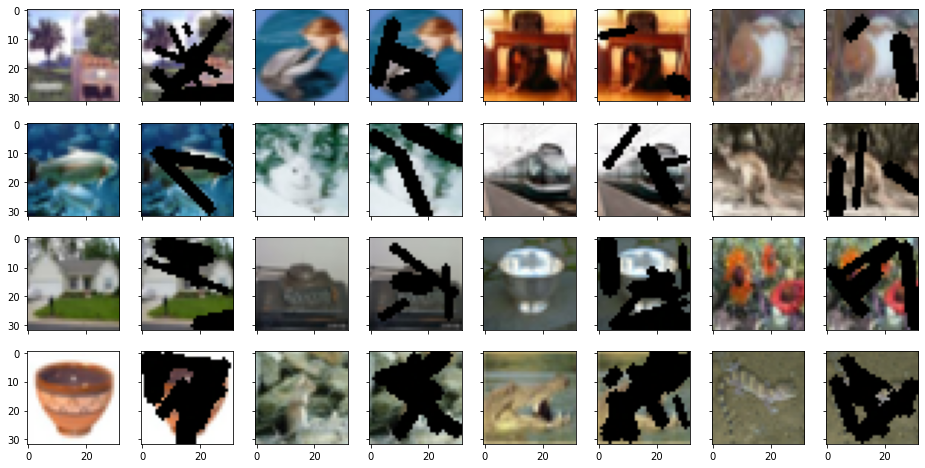

In [33]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [34]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [35]:
from skimage.metrics import structural_similarity as ssim

In [36]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

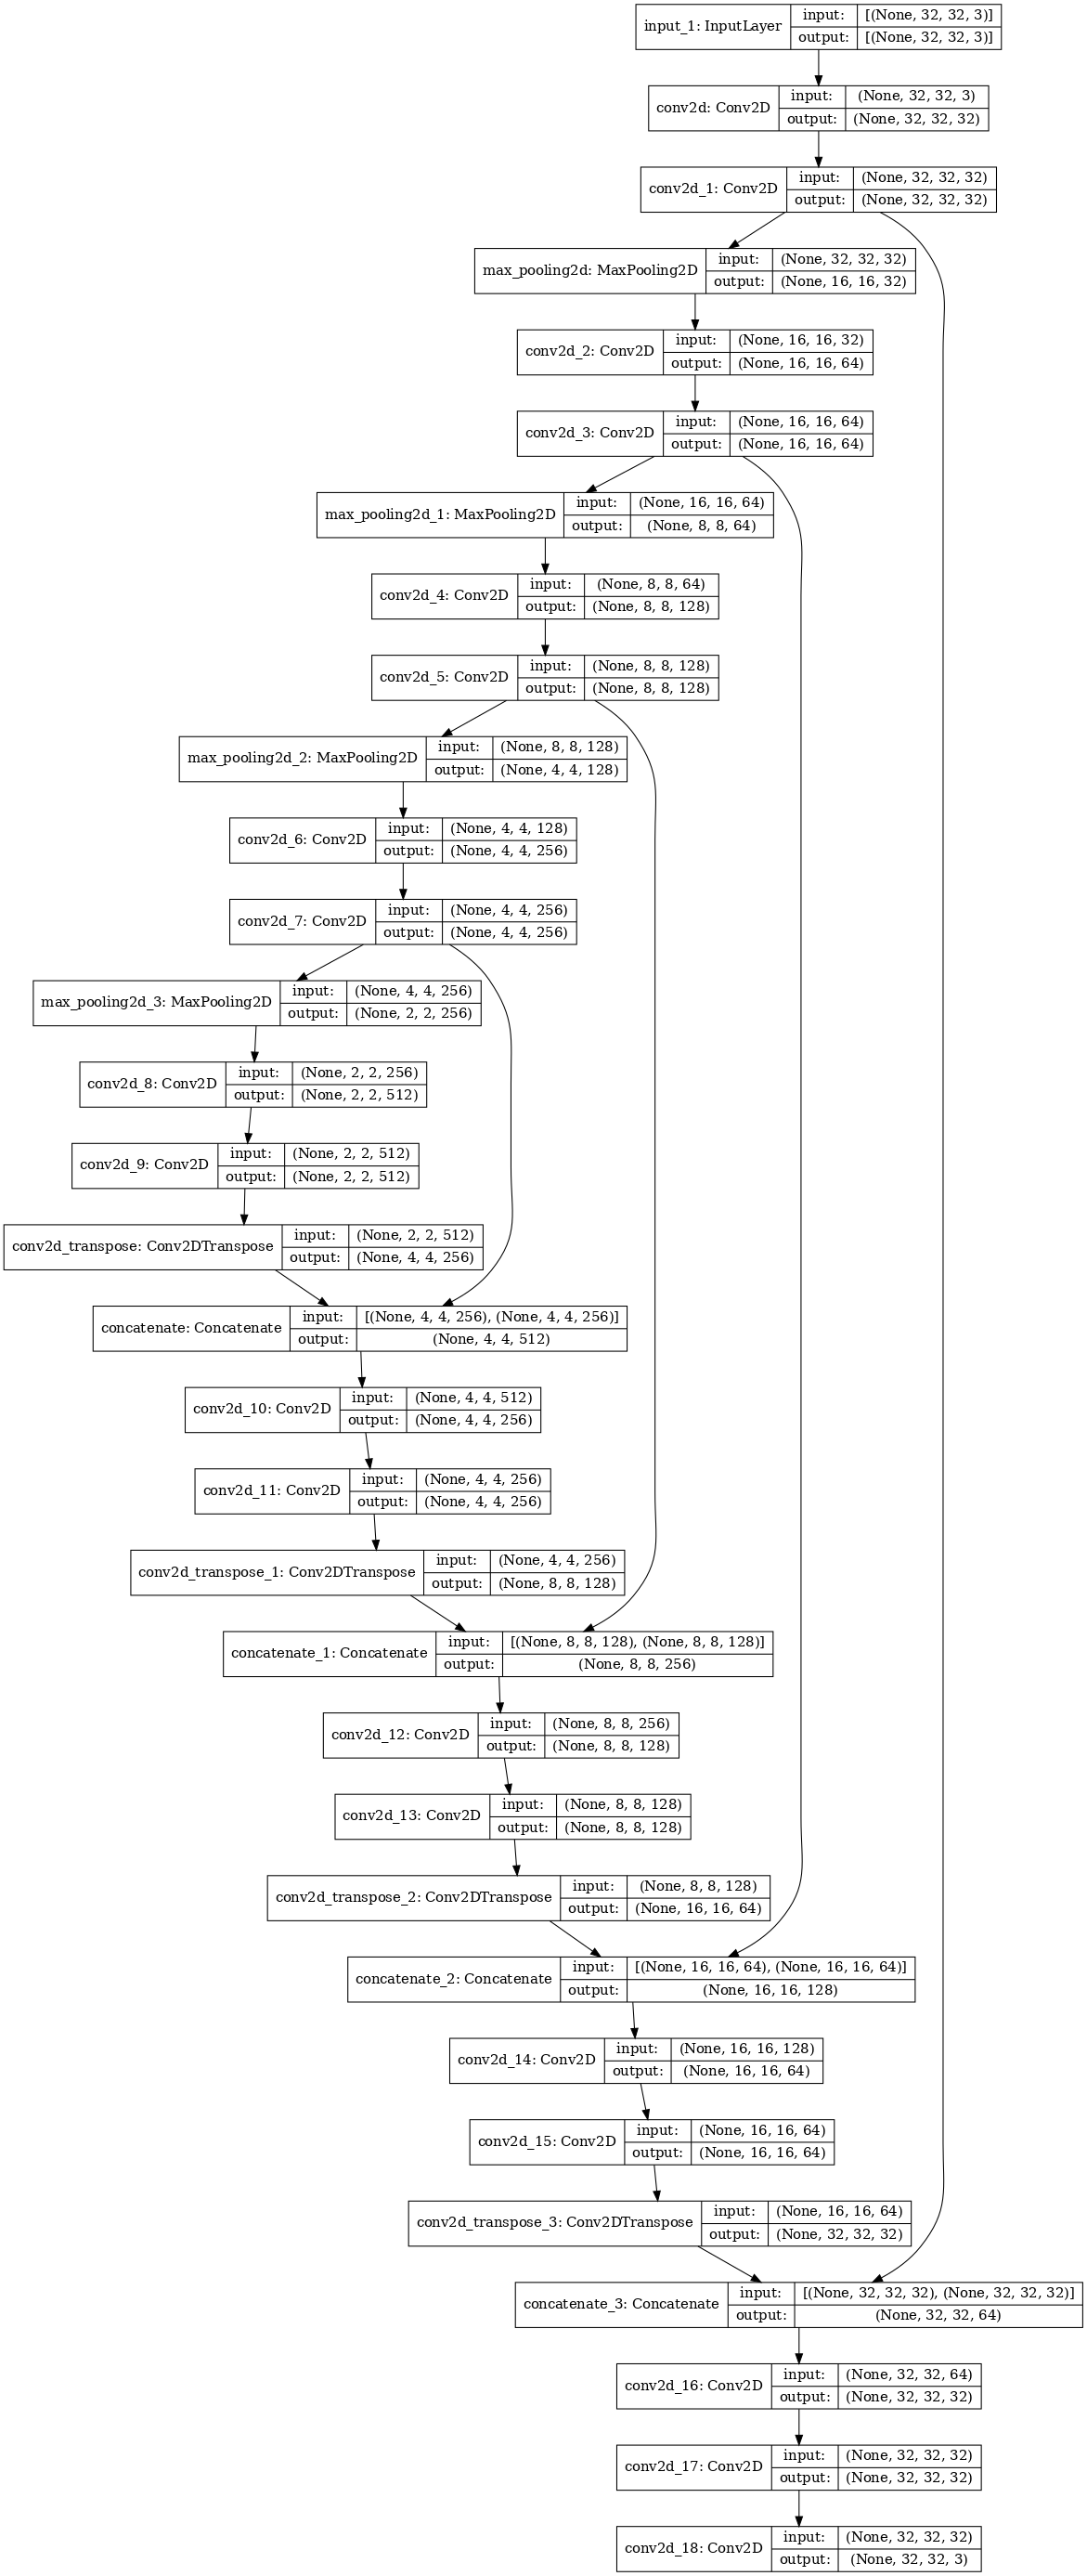

In [37]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

# Train

In [16]:
from tensorflow.keras import mixed_precision

In [17]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8547cc97-3000-957e-b5cd-b43434ae3c0e)


In [38]:
wandb.init(entity='kv1388', project="image-impainting4")

dice_coef,▁▅█
epoch,▁▅█
loss,█▆▁
val_dice_coef,▁▆█
val_loss,█▅▁
best_epoch,2
best_val_loss,0.1719
dice_coef,0.52157
epoch,2
loss,0.18438
val_dice_coef,0.52543


In [39]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        sample_images, sample_labels = testgen[sample_idx]  
        
        images = []
        labels = []
        predictions = []
        
        for i in range(512):
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))

        wandb.log({"images": [wandb.Image(image)
                              for image in images]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                              for inpainted_image in predictions]})

In [40]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=50, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback(),
                     PredictionLogger()])

Epoch 1/50
97/97 [==============================] - 26s 236ms/step - loss: 0.2249 - dice_coef: 0.4888 - val_loss: 0.2248 - val_dice_coef: 0.4894
Epoch 2/50
97/97 [==============================] - 28s 282ms/step - loss: 0.2224 - dice_coef: 0.4889 - val_loss: 0.2218 - val_dice_coef: 0.4897
Epoch 3/50
97/97 [==============================] - 26s 258ms/step - loss: 0.2191 - dice_coef: 0.4894 - val_loss: 0.2182 - val_dice_coef: 0.4905
Epoch 4/50
97/97 [==============================] - 28s 276ms/step - loss: 0.2150 - dice_coef: 0.4901 - val_loss: 0.2135 - val_dice_coef: 0.4915
Epoch 5/50
97/97 [==============================] - 27s 267ms/step - loss: 0.2096 - dice_coef: 0.4916 - val_loss: 0.2076 - val_dice_coef: 0.4939
Epoch 6/50
97/97 [==============================] - 32s 324ms/step - loss: 0.2033 - dice_coef: 0.4950 - val_loss: 0.2005 - val_dice_coef: 0.4977
Epoch 7/50
97/97 [==============================] - 23s 236ms/step - loss: 0.1959 - dice_coef: 0.4988 - val_loss: 0.1926 - val_dic

2022-05-05 17:57:46.781626: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [42]:
model.save('./encoder_decoder_sgd_50epochs_512batch')

# Testing on images

In [46]:
ssim(sample_labels[i],impainted_image[0],channel_axis=2)

0.0033009237004064697

In [53]:
impainted_image[0].shape

(32, 32, 3)

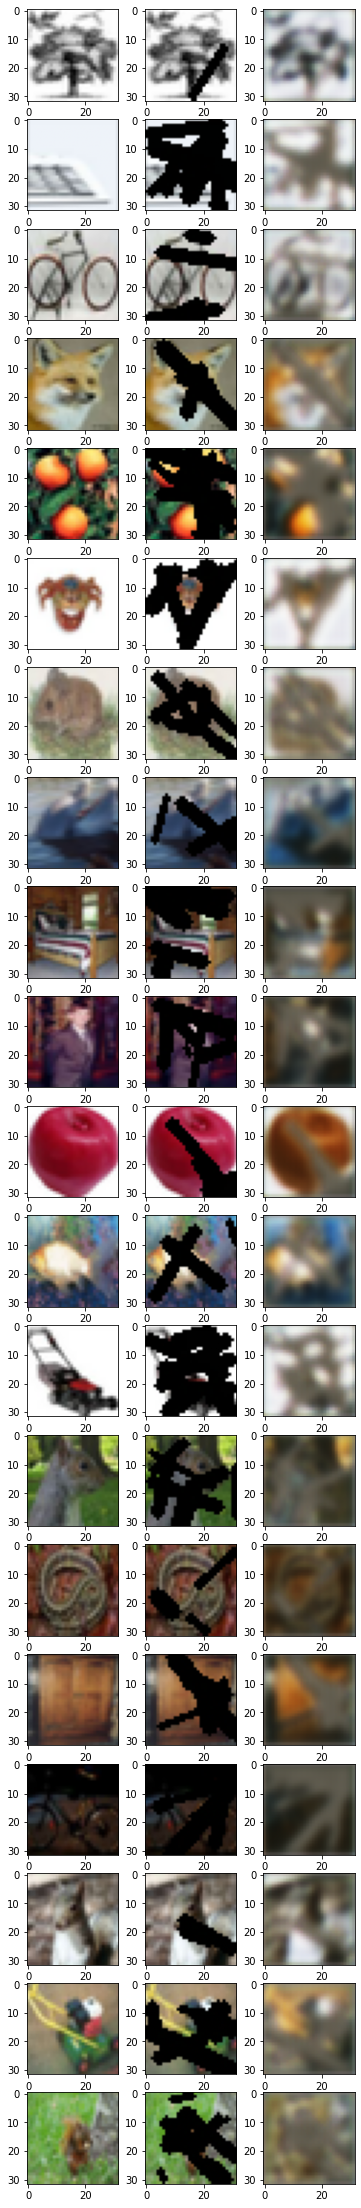

In [56]:
## Examples
# model.load('./encoder_decoder_sgd_50epochs_512batch')
rows = 20
sample_idx = 54
sample_images, sample_labels = traingen[sample_idx]
ssim_test=[]
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(20):
    impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    axs[i][2].imshow(impainted_image[0])
for i in range(len(sample_images)):
    impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    ssim_test.append(ssim(sample_labels[i],impainted_image[0],channel_axis=2))

plt.show()

In [58]:
sum(ssim_test)/len(ssim_test)

0.6057643498576889

In [76]:
!pip install --upgrade tensorflow==1.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.6 MB/s eta 0:00:0000:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 KB 37.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.3
    Uninstalling tensorflow-2.6.3:
      Successfully uninstalled tensorflow-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 

In [77]:
print(tf.__version__)

2.6.3


In [78]:
import cv2
import numpy as np
import tensorflow as tf
from logging import exception
import math
import scipy.stats as st
import os
import urllib
import scipy
from scipy import io

np.random.seed(2018)

"""
https://arxiv.org/abs/1806.03589
"""
def np_free_form_mask(maxVertex, maxLength, maxBrushWidth, maxAngle, h, w):
    mask = np.zeros((h, w, 1), np.float32)
    numVertex = np.random.randint(maxVertex + 1)
    startY = np.random.randint(h)
    startX = np.random.randint(w)
    brushWidth = 0
    for i in range(numVertex):
        angle = np.random.randint(maxAngle + 1)
        angle = angle / 360.0 * 2 * np.pi
        if i % 2 == 0:
            angle = 2 * np.pi - angle
        length = np.random.randint(maxLength + 1)
        brushWidth = np.random.randint(10, maxBrushWidth + 1) // 2 * 2
        nextY = startY + length * np.cos(angle)
        nextX = startX + length * np.sin(angle)

        nextY = np.maximum(np.minimum(nextY, h - 1), 0).astype(np.int)
        nextX = np.maximum(np.minimum(nextX, w - 1), 0).astype(np.int)

        cv2.line(mask, (startY, startX), (nextY, nextX), 1, brushWidth)
        cv2.circle(mask, (startY, startX), brushWidth // 2, 2)

        startY, startX = nextY, nextX
    cv2.circle(mask, (startY, startX), brushWidth // 2, 2)
    return mask


def free_form_mask_tf(parts, maxVertex=16, maxLength=60, maxBrushWidth=14, maxAngle=360, im_size=(256, 256), name='fmask'):
    # mask = np.zeros((im_size[0], im_size[1], 1), dtype=np.float32)
    with tf.variable_scope(name):
        mask = tf.Variable(tf.zeros([1, im_size[0], im_size[1], 1]), name='free_mask')
        maxVertex = tf.constant(maxVertex, dtype=tf.int32)
        maxLength = tf.constant(maxLength, dtype=tf.int32)
        maxBrushWidth = tf.constant(maxBrushWidth, dtype=tf.int32)
        maxAngle = tf.constant(maxAngle, dtype=tf.int32)
        h = tf.constant(im_size[0], dtype=tf.int32)
        w = tf.constant(im_size[1], dtype=tf.int32)

        p = tf.py_func(np_free_form_mask, [maxVertex, maxLength, maxBrushWidth, maxAngle, h, w], tf.float32)
        p = tf.reshape(p, [1, im_size[0], im_size[1], 1])
        for i in range(parts):
            mask = mask + p
        mask = tf.minimum(mask, 1.0)
    return mask


def gauss_kernel(size=21, sigma=3):
    interval = (2 * sigma + 1.0) / size
    x = np.linspace(-sigma-interval/2, sigma+interval/2, size+1)
    ker1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(ker1d, ker1d))
    kernel = kernel_raw / kernel_raw.sum()
    out_filter = np.array(kernel, dtype=np.float32)
    out_filter = out_filter.reshape((size, size, 1, 1))
    return out_filter


def tf_make_guass_var(size, sigma):
    kernel = gauss_kernel(size, sigma)
    var = tf.Variable(tf.convert_to_tensor(kernel))
    return var


def priority_loss_mask(mask, hsize=64, sigma=1/40, iters=7):
    kernel = tf_make_guass_var(hsize, sigma)
    init = 1-mask
    mask_priority = None
    for i in range(iters):
        mask_priority = tf.nn.conv2d(init, kernel, strides=[1,1,1,1], padding='SAME')
        mask_priority = mask_priority * mask
        init = mask_priority + (1-mask)
    return mask_priority


def random_interpolates(x, y, alpha=None):
    """
    x: first dimension as batch_size
    y: first dimension as batch_size
    alpha: [BATCH_SIZE, 1]
    """
    shape = x.get_shape().as_list()
    x = tf.reshape(x, [shape[0], -1])
    y = tf.reshape(y, [shape[0], -1])
    if alpha is None:
        alpha = tf.random_uniform(shape=[shape[0], 1])
    interpolates = x + alpha*(y - x)
    return tf.reshape(interpolates, shape)


def random_bbox(config):
    """Generate a random tlhw with configuration.

    Args:
        config: Config should have configuration including IMG_SHAPES,
            VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.

    Returns:
        tuple: (top, left, height, width)

    """
    img_shape = config.img_shapes
    img_height = img_shape[0]
    img_width = img_shape[1]
    if config.random_mask is True:
        maxt = img_height - config.margins[0] - config.mask_shapes[0]
        maxl = img_width - config.margins[1] - config.mask_shapes[1]
        t = tf.random_uniform(
            [], minval=config.margins[0], maxval=maxt, dtype=tf.int32)
        l = tf.random_uniform(
            [], minval=config.margins[1], maxval=maxl, dtype=tf.int32)
    else:
        t = config.mask_shapes[0]//2
        l = config.mask_shapes[1]//2
    h = tf.constant(config.mask_shapes[0])
    w = tf.constant(config.mask_shapes[1])
    return (t, l, h, w)


def bbox2mask(bbox, config, name='mask'):
    """Generate mask tensor from bbox.

    Args:
        bbox: configuration tuple, (top, left, height, width)
        config: Config should have configuration including IMG_SHAPES,
            MAX_DELTA_HEIGHT, MAX_DELTA_WIDTH.

    Returns:
        tf.Tensor: output with shape [1, H, W, 1]

    """
    def npmask(bbox, height, width, delta_h, delta_w):
        mask = np.zeros((1, height, width, 1), np.float32)
        h = np.random.randint(delta_h//2+1)
        w = np.random.randint(delta_w//2+1)
        mask[:, bbox[0]+h:bbox[0]+bbox[2]-h,
             bbox[1]+w:bbox[1]+bbox[3]-w, :] = 1.
        return mask
    with tf.variable_scope(name), tf.device('/cpu:0'):
        img_shape = config.img_shapes
        height = img_shape[0]
        width = img_shape[1]
        mask = tf.py_func(
            npmask,
            [bbox, height, width,
             config.max_delta_shapes[0], config.max_delta_shapes[1]],
            tf.float32, stateful=False)
        mask.set_shape([1] + [height, width] + [1])
    return mask


def local_patch(x, bbox):
    """Crop local patch according to bbox.

    Args:
        x: input
        bbox: (top, left, height, width)

    Returns:
        tf.Tensor: local patch

    """
    x = tf.image.crop_to_bounding_box(x, bbox[0], bbox[1], bbox[2], bbox[3])
    return x


def gradients_penalty(x, y, mask=None, norm=1.):
    """Improved Training of Wasserstein GANs

    - https://arxiv.org/abs/1704.00028
    """
    gradients = tf.gradients(y, x)[0]
    if mask is None:
        mask = tf.ones_like(gradients)
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients) * mask, axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(slopes - norm))


def gan_wgan_loss(pos, neg, name='gan_wgan_loss'):
    """
    wgan loss function for GANs.

    - Wasserstein GAN: https://arxiv.org/abs/1701.07875
    """
    with tf.variable_scope(name):
        d_loss = tf.reduce_mean(neg-pos)
        g_loss = -tf.reduce_mean(neg)
        tf.summary.scalar('d_loss', d_loss)
        tf.summary.scalar('g_loss', g_loss)
        tf.summary.scalar('pos_value_avg', tf.reduce_mean(pos))
        tf.summary.scalar('neg_value_avg', tf.reduce_mean(neg))
    return g_loss, d_loss


def average_gradients(tower_grads):
    """ Calculate the average gradient for each shared variable across
    all towers.

    **Note** that this function provides a synchronization point
    across all towers.

    Args:
        tower_grads: List of lists of (gradient, variable) tuples.
            The outer list is over individual gradients. The inner list is
            over the gradient calculation for each tower.

    Returns:
        List of pairs of (gradient, variable) where the gradient
            has been averaged across all towers.

    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        v = grad_and_vars[0][1]
        # sum
        grad = tf.add_n([x[0] for x in grad_and_vars])
        # average
        grad = grad / float(len(tower_grads))
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads


"""
id-mrf
"""
from enum import Enum

class Distance(Enum):
    L2 = 0
    DotProduct = 1

class CSFlow:
    def __init__(self, sigma=float(0.1), b=float(1.0)):
        self.b = b
        self.sigma = sigma

    def __calculate_CS(self, scaled_distances, axis_for_normalization=3):
        self.scaled_distances = scaled_distances
        self.cs_weights_before_normalization = tf.exp((self.b - scaled_distances) / self.sigma, name='weights_before_normalization')
        self.cs_NHWC = CSFlow.sum_normalize(self.cs_weights_before_normalization, axis_for_normalization)

    def reversed_direction_CS(self):
        cs_flow_opposite = CSFlow(self.sigma, self.b)
        cs_flow_opposite.raw_distances = self.raw_distances
        work_axis = [1, 2]
        relative_dist = cs_flow_opposite.calc_relative_distances(axis=work_axis)
        cs_flow_opposite.__calculate_CS(relative_dist, work_axis)
        return cs_flow_opposite

    # --
    @staticmethod
    def create_using_L2(I_features, T_features, sigma=float(0.1), b=float(1.0)):
        cs_flow = CSFlow(sigma, b)
        with tf.name_scope('CS'):
            sT = T_features.shape.as_list()
            sI = I_features.shape.as_list()

            Ivecs = tf.reshape(I_features, (sI[0], -1, sI[3]))
            Tvecs = tf.reshape(T_features, (sI[0], -1, sT[3]))
            r_Ts = tf.reduce_sum(Tvecs * Tvecs, 2)
            r_Is = tf.reduce_sum(Ivecs * Ivecs, 2)
            raw_distances_list = []
            for i in range(sT[TensorAxis.N]):
                Ivec, Tvec, r_T, r_I = Ivecs[i], Tvecs[i], r_Ts[i], r_Is[i]
                A = tf.matmul(Tvec,tf.transpose(Ivec))
                cs_flow.A = A
                # A = tf.matmul(Tvec, tf.transpose(Ivec))
                r_T = tf.reshape(r_T, [-1, 1])  # turn to column vector
                dist = r_T - 2 * A + r_I
                cs_shape = sI[:3] + [dist.shape[0].value]
                cs_shape[0] = 1
                dist = tf.reshape(tf.transpose(dist), cs_shape)
                # protecting against numerical problems, dist should be positive
                dist = tf.maximum(float(0.0), dist)
                # dist = tf.sqrt(dist)
                raw_distances_list += [dist]

            cs_flow.raw_distances = tf.convert_to_tensor([tf.squeeze(raw_dist, axis=0) for raw_dist in raw_distances_list])

            relative_dist = cs_flow.calc_relative_distances()
            cs_flow.__calculate_CS(relative_dist)
            return cs_flow

    #--
    @staticmethod
    def create_using_dotP(I_features, T_features, sigma=float(1.0), b=float(1.0)):
        cs_flow = CSFlow(sigma, b)
        with tf.name_scope('CS'):
            # prepare feature before calculating cosine distance
            T_features, I_features = cs_flow.center_by_T(T_features, I_features)
            with tf.name_scope('TFeatures'):
                T_features = CSFlow.l2_normalize_channelwise(T_features)
            with tf.name_scope('IFeatures'):
                I_features = CSFlow.l2_normalize_channelwise(I_features)
                # work seperatly for each example in dim 1
                cosine_dist_l = []
                N, _, _, _ = T_features.shape.as_list()
                for i in range(N):
                    T_features_i = tf.expand_dims(T_features[i, :, :, :], 0)
                    I_features_i = tf.expand_dims(I_features[i, :, :, :], 0)
                    patches_i = cs_flow.patch_decomposition(T_features_i)
                    cosine_dist_i = tf.nn.conv2d(I_features_i, patches_i, strides=[1, 1, 1, 1],
                                                        padding='VALID', use_cudnn_on_gpu=True, name='cosine_dist')
                    cosine_dist_l.append(cosine_dist_i)

                cs_flow.cosine_dist = tf.concat(cosine_dist_l, axis = 0)

                cosine_dist_zero_to_one = -(cs_flow.cosine_dist - 1) / 2
                cs_flow.raw_distances = cosine_dist_zero_to_one

                relative_dist = cs_flow.calc_relative_distances()
                cs_flow.__calculate_CS(relative_dist)
                return cs_flow

    def calc_relative_distances(self, axis=3):
        epsilon = 1e-5
        div = tf.reduce_min(self.raw_distances, axis=axis, keep_dims=True)
        # div = tf.reduce_mean(self.raw_distances, axis=axis, keep_dims=True)
        relative_dist = self.raw_distances / (div + epsilon)
        return relative_dist

    def weighted_average_dist(self, axis=3):
        if not hasattr(self, 'raw_distances'):
            raise exception('raw_distances property does not exists. cant calculate weighted average l2')

        multiply = self.raw_distances * self.cs_NHWC
        return tf.reduce_sum(multiply, axis=axis, name='weightedDistPerPatch')

    # --
    @staticmethod
    def create(I_features, T_features, distance : Distance, nnsigma=float(1.0), b=float(1.0)):
        if distance.value == Distance.DotProduct.value:
            cs_flow = CSFlow.create_using_dotP(I_features, T_features, nnsigma, b)
        elif distance.value == Distance.L2.value:
            cs_flow = CSFlow.create_using_L2(I_features, T_features, nnsigma, b)
        else:
            raise "not supported distance " + distance.__str__()
        return cs_flow

    @staticmethod
    def sum_normalize(cs, axis=3):
        reduce_sum = tf.reduce_sum(cs, axis, keep_dims=True, name='sum')
        return tf.divide(cs, reduce_sum, name='sumNormalized')

    def center_by_T(self, T_features, I_features):
        # assuming both input are of the same size

        # calculate stas over [batch, height, width], expecting 1x1xDepth tensor
        axes = [0, 1, 2]
        self.meanT, self.varT = tf.nn.moments(
            T_features, axes, name='TFeatures/moments')
        # we do not divide by std since its causing the histogram
        # for the final cs to be very thin, so the NN weights
        # are not distinctive, giving similar values for all patches.
        # stdT = tf.sqrt(varT, "stdT")
        # correct places with std zero
        # stdT[tf.less(stdT, tf.constant(0.001))] = tf.constant(1)
        with tf.name_scope('TFeatures/centering'):
            self.T_features_centered = T_features - self.meanT
        with tf.name_scope('IFeatures/centering'):
            self.I_features_centered = I_features - self.meanT

        return self.T_features_centered, self.I_features_centered

    @staticmethod
    def l2_normalize_channelwise(features):
        norms = tf.norm(features, ord='euclidean', axis=3, name='norm')
        # expanding the norms tensor to support broadcast division
        norms_expanded = tf.expand_dims(norms, 3)
        features = tf.divide(features, norms_expanded, name='normalized')
        return features

    def patch_decomposition(self, T_features):
        # patch decomposition
        patch_size = 1
        patches_as_depth_vectors = tf.extract_image_patches(
            images=T_features, ksizes=[1, patch_size, patch_size, 1],
            strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='VALID',
            name='patches_as_depth_vectors')

        self.patches_NHWC = tf.reshape(
            patches_as_depth_vectors,
            shape=[-1, patch_size, patch_size, patches_as_depth_vectors.shape[3].value],
            name='patches_PHWC')

        self.patches_HWCN = tf.transpose(
            self.patches_NHWC,
            perm=[1, 2, 3, 0],
            name='patches_HWCP')  # tf.conv2 ready format

        return self.patches_HWCN


def mrf_loss(T_features, I_features, distance=Distance.DotProduct, nnsigma=float(1.0)):
    T_features = tf.convert_to_tensor(T_features, dtype=tf.float32)
    I_features = tf.convert_to_tensor(I_features, dtype=tf.float32)

    with tf.name_scope('cx'):
        cs_flow = CSFlow.create(I_features, T_features, distance, nnsigma)
        # sum_normalize:
        height_width_axis = [1, 2]
        # To:
        cs = cs_flow.cs_NHWC
        k_max_NC = tf.reduce_max(cs, axis=height_width_axis)
        CS = tf.reduce_mean(k_max_NC, axis=[1])
        CS_as_loss = 1 - CS
        CS_loss = -tf.log(1 - CS_as_loss)
        CS_loss = tf.reduce_mean(CS_loss)
        return CS_loss


def random_sampling(tensor_in, n, indices=None):
    N, H, W, C = tf.convert_to_tensor(tensor_in).shape.as_list()
    S = H * W
    tensor_NSC = tf.reshape(tensor_in, [N, S, C])
    all_indices = list(range(S))
    shuffled_indices = tf.random_shuffle(all_indices)
    indices = tf.gather(shuffled_indices, list(range(n)), axis=0) if indices is None else indices
    res = tf.gather(tensor_NSC, indices, axis=1)
    return res, indices


def random_pooling(feats, output_1d_size=100):
    is_input_tensor = type(feats) is tf.Tensor

    if is_input_tensor:
        feats = [feats]

    # convert all inputs to tensors
    feats = [tf.convert_to_tensor(feats_i) for feats_i in feats]

    N, H, W, C = feats[0].shape.as_list()
    feats_sampled_0, indices = random_sampling(feats[0], output_1d_size ** 2)
    res = [feats_sampled_0]
    for i in range(1, len(feats)):
        feats_sampled_i, _ = random_sampling(feats[i], -1, indices)
        res.append(feats_sampled_i)

    res = [tf.reshape(feats_sampled_i, [N, output_1d_size, output_1d_size, C]) for feats_sampled_i in res]
    if is_input_tensor:
        return res[0]
    return res


def crop_quarters(feature_tensor):
    N, fH, fW, fC = feature_tensor.shape.as_list()
    quarters_list = []
    quarter_size = [N, round(fH / 2), round(fW / 2), fC]
    quarters_list.append(tf.slice(feature_tensor, [0, 0, 0, 0], quarter_size))
    quarters_list.append(tf.slice(feature_tensor, [0, round(fH / 2), 0, 0], quarter_size))
    quarters_list.append(tf.slice(feature_tensor, [0, 0, round(fW / 2), 0], quarter_size))
    quarters_list.append(tf.slice(feature_tensor, [0, round(fH / 2), round(fW / 2), 0], quarter_size))
    feature_tensor = tf.concat(quarters_list, axis=0)
    return feature_tensor


def id_mrf_reg_feat(feat_A, feat_B, config):
    if config.crop_quarters is True:
        feat_A = crop_quarters(feat_A)
        feat_B = crop_quarters(feat_B)

    N, fH, fW, fC = feat_A.shape.as_list()
    if fH * fW <= config.max_sampling_1d_size ** 2:
        print(' #### Skipping pooling ....')
    else:
        print(' #### pooling %d**2 out of %dx%d' % (config.max_sampling_1d_size, fH, fW))
        feat_A, feat_B = random_pooling([feat_A, feat_B], output_1d_size=config.max_sampling_1d_size)

    return mrf_loss(feat_A, feat_B, distance=config.Dist, nnsigma=config.nn_stretch_sigma)


from easydict import EasyDict as edict
# scale of im_src and im_dst: [-1, 1]
def id_mrf_reg(im_src, im_dst, config):
    vgg = Vgg19(filepath=config.vgg19_path)

    src_vgg = vgg.build_vgg19((im_src + 1) * 127.5)
    dst_vgg = vgg.build_vgg19((im_dst + 1) * 127.5, reuse=True)

    feat_style_layers = config.feat_style_layers
    feat_content_layers = config.feat_content_layers

    mrf_style_w = config.mrf_style_w
    mrf_content_w = config.mrf_content_w

    mrf_config = edict()
    mrf_config.crop_quarters = False
    mrf_config.max_sampling_1d_size = 65
    mrf_config.Dist = Distance.DotProduct
    mrf_config.nn_stretch_sigma = 0.5  # 0.1

    mrf_style_loss = [w * id_mrf_reg_feat(src_vgg[layer], dst_vgg[layer], mrf_config)
                      for layer, w in feat_style_layers.items()]
    mrf_style_loss = tf.reduce_sum(mrf_style_loss)

    mrf_content_loss = [w * id_mrf_reg_feat(src_vgg[layer], dst_vgg[layer], mrf_config)
                        for layer, w in feat_content_layers.items()]
    mrf_content_loss = tf.reduce_sum(mrf_content_loss)

    id_mrf_loss = mrf_style_loss * mrf_style_w + mrf_content_loss * mrf_content_w
    return id_mrf_loss


class Vgg19(object):
    def __init__(self, filepath=None):
        self.mean = np.array([123.6800, 116.7790, 103.9390]).reshape((1, 1, 1, 3))
        self.vgg_weights = filepath if filepath is not None else os.path.join('vgg19_weights', 'imagenet-vgg-verydeep-19.mat')
        if os.path.exists(self.vgg_weights) is False:
            self.vgg_weights = os.path.join('vgg19_weights', 'imagenet-vgg-verydeep-19.mat')
            if os.path.isdir('vgg19_weights') is False:
                os.mkdir('vgg19_weights')
            url = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
            print('Downloading vgg19..')
            urllib.request.urlretrieve(url, self.vgg_weights)
            print('vgg19 weights have been downloaded and stored in {}'.format(self.vgg_weights))

    def build_net(self, ntype, nin, nwb=None, name=None):
        if ntype == 'conv':
            return tf.nn.relu(tf.nn.conv2d(nin, nwb[0], strides=[1, 1, 1, 1], padding='SAME', name=name) + nwb[1])
        elif ntype == 'pool':
            return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    def get_weight_bias(self, vgg_layers, i):
        weights = vgg_layers[i][0][0][2][0][0]
        weights = tf.constant(weights)
        bias = vgg_layers[i][0][0][2][0][1]
        bias = tf.constant(np.reshape(bias, (bias.size)))
        return weights, bias

    def build_vgg19(self, input, reuse=False):
        with tf.variable_scope('vgg19', reuse=reuse):
            net = {}
            # vgg_rawnet = scipy.io.loadmat(self.vgg_weights)
            vgg_rawnet = io.loadmat(self.vgg_weights)
            vgg_layers = vgg_rawnet['layers'][0]
            net['input'] = input - self.mean
            net['conv1_1'] = self.build_net('conv', net['input'], self.get_weight_bias(vgg_layers, 0),
                                            name='vgg_conv1_1')
            net['conv1_2'] = self.build_net('conv', net['conv1_1'], self.get_weight_bias(vgg_layers, 2),
                                            name='vgg_conv1_2')
            net['pool1'] = self.build_net('pool', net['conv1_2'])
            net['conv2_1'] = self.build_net('conv', net['pool1'], self.get_weight_bias(vgg_layers, 5),
                                            name='vgg_conv2_1')
            net['conv2_2'] = self.build_net('conv', net['conv2_1'], self.get_weight_bias(vgg_layers, 7),
                                            name='vgg_conv2_2')
            net['pool2'] = self.build_net('pool', net['conv2_2'])
            net['conv3_1'] = self.build_net('conv', net['pool2'], self.get_weight_bias(vgg_layers, 10),
                                            name='vgg_conv3_1')
            net['conv3_2'] = self.build_net('conv', net['conv3_1'], self.get_weight_bias(vgg_layers, 12),
                                            name='vgg_conv3_2')
            net['conv3_3'] = self.build_net('conv', net['conv3_2'], self.get_weight_bias(vgg_layers, 14),
                                            name='vgg_conv3_3')
            net['conv3_4'] = self.build_net('conv', net['conv3_3'], self.get_weight_bias(vgg_layers, 16),
                                            name='vgg_conv3_4')
            net['pool3'] = self.build_net('pool', net['conv3_4'])
            net['conv4_1'] = self.build_net('conv', net['pool3'], self.get_weight_bias(vgg_layers, 19),
                                            name='vgg_conv4_1')
            net['conv4_2'] = self.build_net('conv', net['conv4_1'], self.get_weight_bias(vgg_layers, 21),
                                            name='vgg_conv4_2')
            net['conv4_3'] = self.build_net('conv', net['conv4_2'], self.get_weight_bias(vgg_layers, 23),
                                            name='vgg_conv4_3')
            net['conv4_4'] = self.build_net('conv', net['conv4_3'], self.get_weight_bias(vgg_layers, 25),
                                            name='vgg_conv4_4')
            net['pool4'] = self.build_net('pool', net['conv4_4'])
            net['conv5_1'] = self.build_net('conv', net['pool4'], self.get_weight_bias(vgg_layers, 28),
                                            name='vgg_conv5_1')
            net['conv5_2'] = self.build_net('conv', net['conv5_1'], self.get_weight_bias(vgg_layers, 30),
                                            name='vgg_conv5_2')
            net['conv5_3'] = self.build_net('conv', net['conv5_2'], self.get_weight_bias(vgg_layers, 32),
                                            name='vgg_conv5_3')
            net['conv5_4'] = self.build_net('conv', net['conv5_3'], self.get_weight_bias(vgg_layers, 34),
                                            name='vgg_conv5_4')
            net['pool5'] = self.build_net('pool', net['conv5_4'])
        return net


In [79]:
import numpy as np
import cv2
import math
import time
import shutil
import os, re
import tensorflow as tf

def np_free_form_mask(maxVertex, maxLength, maxBrushWidth, maxAngle, h, w):
    mask = np.zeros((h, w, 1), np.float32)
    numVertex = np.random.randint(maxVertex + 1)
    startY = np.random.randint(h)
    startX = np.random.randint(w)
    brushWidth = 0
    for i in range(numVertex):
        angle = np.random.randint(maxAngle + 1)
        angle = angle / 360.0 * 2 * np.pi
        if i % 2 == 0:
            angle = 2 * np.pi - angle
        length = np.random.randint(maxLength + 1)
        brushWidth = np.random.randint(10, maxBrushWidth + 1) // 2 * 2
        nextY = startY + length * np.cos(angle)
        nextX = startX + length * np.sin(angle)

        nextY = np.maximum(np.minimum(nextY, h - 1), 0).astype(np.int)
        nextX = np.maximum(np.minimum(nextX, w - 1), 0).astype(np.int)

        cv2.line(mask, (startY, startX), (nextY, nextX), 1, brushWidth)
        cv2.circle(mask, (startY, startX), brushWidth // 2, 2)

        startY, startX = nextY, nextX
    cv2.circle(mask, (startY, startX), brushWidth // 2, 2)
    return mask

def f2uint(x):
    if x.__class__ == tf.Tensor:
        return tf.cast(tf.clip_by_value((x+1)*127.5, 0, 255), tf.uint8)
    else:
        return np.clip((x+1)*127.5, 0, 255).astype(np.uint8)


def generate_mask_rect(im_shapes, mask_shapes, rand=True):
    mask = np.zeros((im_shapes[0], im_shapes[1])).astype(np.float32)
    if rand:
        of0 = np.random.randint(0, im_shapes[0]-mask_shapes[0])
        of1 = np.random.randint(0, im_shapes[1]-mask_shapes[1])
    else:
        of0 = (im_shapes[0]-mask_shapes[0])//2
        of1 = (im_shapes[1]-mask_shapes[1])//2
    mask[of0:of0+mask_shapes[0], of1:of1+mask_shapes[1]] = 1
    mask = np.expand_dims(mask, axis=2)
    return mask


def generate_mask_stroke(im_size, parts=16, maxVertex=24, maxLength=100, maxBrushWidth=24, maxAngle=360):
    h, w = im_size[:2]
    mask = np.zeros((h, w, 1), dtype=np.float32)
    for i in range(parts):
        mask = mask + np_free_form_mask(maxVertex, maxLength, maxBrushWidth, maxAngle, h, w)
    mask = np.minimum(mask, 1.0)
    return mask



## Modified UNET

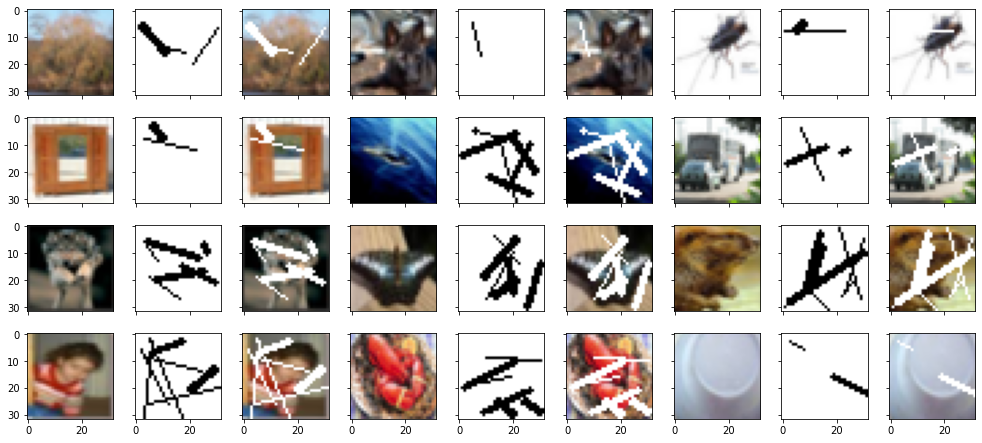

In [95]:

## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=512, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

# Legend: Original Image | Mask generated | Masked Image

## Examples
sample_idx = 90 ## Change this to see different batches

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()



In [86]:

## Reference: https://github.com/MathiasGruber/PConv-Keras/blob/master/libs/pconv_layer.py
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [87]:
class InpaintingModel_2:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2



In [98]:
keras.backend.clear_session()
model = InpaintingModel_2().prepare_model()
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

wandb.init(entity='kv1388', project="image-impainting-pconv-sgd")

class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

        wandb.log({"masked_images": [wandb.Image(m_image)
                              for m_image in m_images]})
        wandb.log({"masks": [wandb.Image(mask)
                              for mask in binary_masks]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                              for inpainted_image in predictions]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})
        



/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

dice_coef,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice_coef,██▇▇▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,49
best_val_loss,0.22289
dice_coef,0.46921
epoch,49
loss,0.22181
val_dice_coef,0.46978


In [99]:
_ = model.fit_generator(traingen, validation_data=testgen, 
          epochs=50, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback(),
                     PredictionLogger()])


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
2022-05-05 21:32:06.392913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 21:32:06.394510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 21:32:06.395405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 21:32:06.396631: I tensorflow/stream_executor/cuda/cuda_

Epoch 1/50
97/97 [==============================] - ETA: 0s - batch: 48.0000 - size: 512.0000 - loss: 0.2261 - dice_coef: 0.4881

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


97/97 [==============================] - 41s 386ms/step - batch: 48.0000 - size: 512.0000 - loss: 0.2261 - dice_coef: 0.4881 - val_loss: 0.2269 - val_dice_coef: 0.4881 - _timestamp: 1651786365.0000 - _runtime: 44.0000
Epoch 2/50
97/97 [==============================] - 37s 384ms/step - batch: 48.0000 - size: 512.0000 - loss: 0.2257 - dice_coef: 0.4868 - val_loss: 0.2265 - val_dice_coef: 0.4868 - _timestamp: 1651786401.0000 - _runtime: 80.0000
Epoch 3/50
97/97 [==============================] - 43s 444ms/step - batch: 48.0000 - size: 512.0000 - loss: 0.2252 - dice_coef: 0.4855 - val_loss: 0.2261 - val_dice_coef: 0.4856 - _timestamp: 1651786443.0000 - _runtime: 122.0000
Epoch 4/50
97/97 [==============================] - 35s 363ms/step - batch: 48.0000 - size: 512.0000 - loss: 0.2249 - dice_coef: 0.4845 - val_loss: 0.2258 - val_dice_coef: 0.4846 - _timestamp: 1651786481.0000 - _runtime: 160.0000
Epoch 5/50
97/97 [==============================] - 40s 417ms/step - batch: 48.0000 - size: 5

In [100]:
model.save('./encoder_decoder_pconv_sgd_50epochs_512batch')


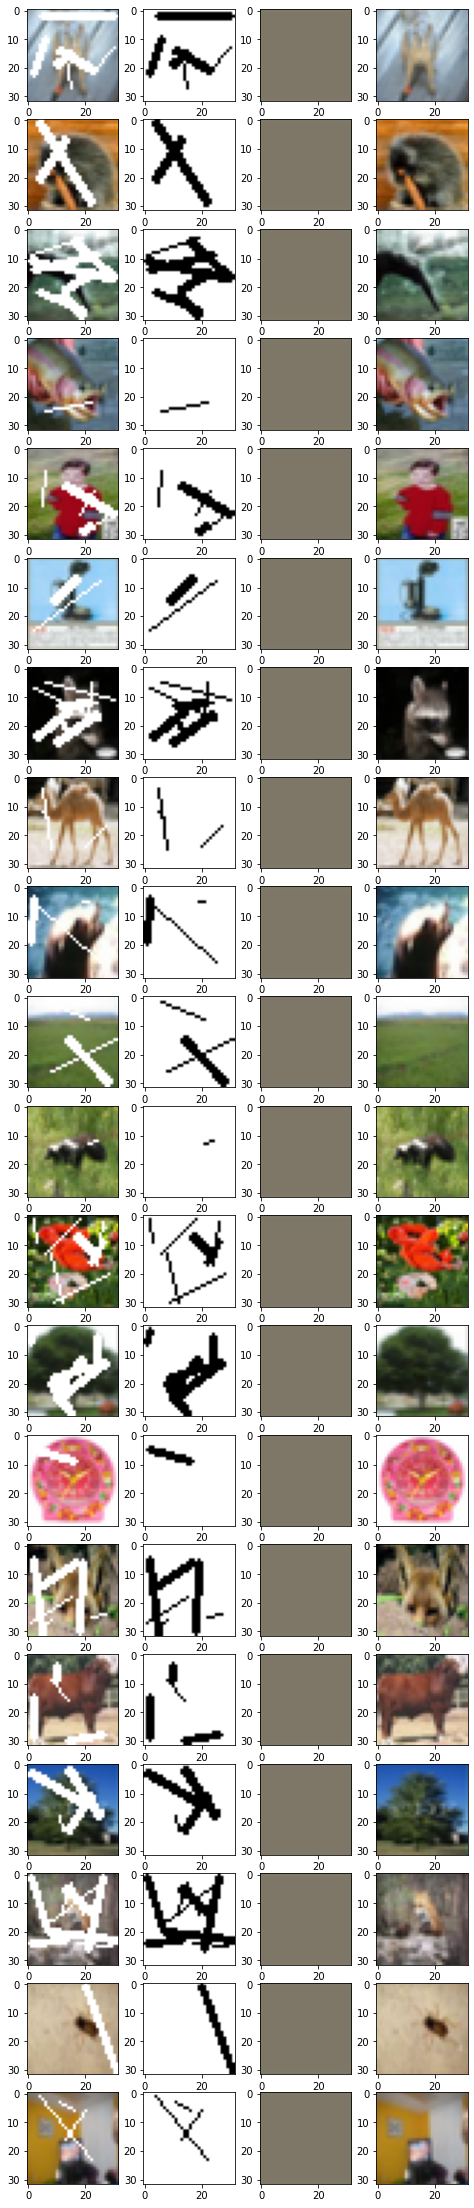

In [105]:
rows = 20
sample_idx = 54
[masked_images, masks], sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(20):
    inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
    impainted_image = model.predict(inputs)
    axs[i][0].imshow(masked_images[i])
    axs[i][1].imshow(masks[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
    axs[i][3].imshow(sample_labels[i])
plt.show()


ssim_test=[]

for i in range(len(sample_labels)):
    inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
    impainted_image = model.predict(inputs)
    ssim_test.append(ssim(sample_labels[i],impainted_image[0],channel_axis=2))




In [106]:
max(ssim_test)

0.8238542677083389

In [107]:

sum(ssim_test)/len(ssim_test)

0.2721480063778668